Importing the Dependencies

In [183]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Device Configuration

In [184]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
device

device(type='mps')

Data Collection and Preprocessing

In [185]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
X = data.data
y =  data.target

In [186]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [188]:
df.shape

(569, 30)

In [189]:
df.isna().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

In [190]:
df.duplicated().sum()

np.int64(0)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [192]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(569, 30)
(455, 30)
(114, 30)


In [193]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

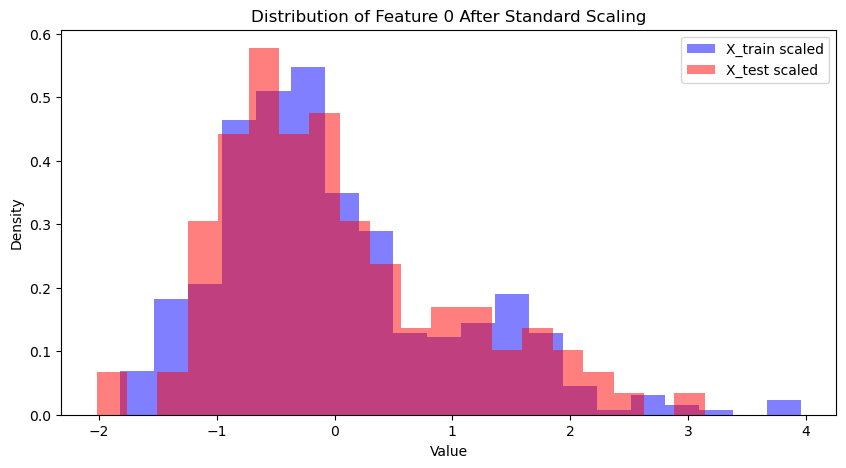

In [194]:
feature_idx = 0  

feature_train_scaled = X_train[:, feature_idx]
feature_test_scaled = X_test[:, feature_idx]

plt.figure(figsize=(10,5))
plt.hist(feature_train_scaled, bins=20, alpha=0.5, label='X_train scaled', color='blue', density=True)
plt.hist(feature_test_scaled, bins=20, alpha=0.5, label='X_test scaled', color='red', density=True)

plt.title(f"Distribution of Feature {feature_idx} After Standard Scaling")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

Testing some ML Algorithms

- SVM

In [195]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [196]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [197]:
y_test_pred = svm_model.predict(X_test)

In [198]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



- KNN

In [199]:
from sklearn.neighbors import KNeighborsClassifier

In [200]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [201]:
y_test_pred = knn_model.predict(X_test)

In [202]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.96      0.96      0.96        71

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



- RFC

In [203]:
from sklearn.ensemble import RandomForestClassifier

In [204]:
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [205]:
y_test_pred = rfc_model.predict(X_test)

In [206]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



- Logistic Regression

In [207]:
from sklearn.linear_model import LogisticRegression

In [208]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [209]:
y_test_pred = lr_model.predict(X_test)

In [210]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



- Decision Tree Classifier

In [211]:
from sklearn.tree import DecisionTreeClassifier

In [212]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [213]:
y_test_pred = tree_model.predict(X_test)

In [214]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.96      0.96      0.96        71

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



Turning Data into Tensors

In [215]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

Neural Network Architecture

In [216]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out) 
        return out

Define Hyperparameters

In [217]:
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
lr = 0.001
epochs = 200

Create the Model

In [218]:
model = NeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)

Setting up Loss and the Optimizer

In [219]:
criterion = nn.BCELoss()
criterion

BCELoss()

In [220]:
optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Writing the Loop

In [221]:
epoch_count, loss_values, test_loss_values = [], [], []
train_accuracy_values, test_accuracy_values = [], []

for epoch in range(epochs):
    model.train()
    y_preds = model(X_train)
    loss = criterion(y_preds, y_train.view(-1,1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        train_pred_labels = y_preds.round()
        correct_train = (train_pred_labels == y_train.view(-1,1)).float().sum()
        train_acc = correct_train / y_train.size(0)
        
        test_preds = model(X_test)
        test_loss = criterion(test_preds, y_test.view(-1,1))
        
        test_pred_labels = test_preds.round()
        correct_test = (test_pred_labels == y_test.view(-1,1)).float().sum()
        test_acc = correct_test / y_test.size(0)
    
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        train_accuracy_values.append(train_acc.item())
        test_accuracy_values.append(test_acc.item())
        print(f"Epoch {epoch}: "
              f"Loss={loss.item():.4f}, Test Loss={test_loss.item():.4f}, "
              f"Train Acc={train_acc.item():.4f}, Test Acc={test_acc.item():.4f}")

Epoch 0: Loss=0.7361, Test Loss=0.7152, Train Acc=0.2813, Test Acc=0.4123
Epoch 10: Loss=0.5710, Test Loss=0.5489, Train Acc=0.8769, Test Acc=0.9474
Epoch 20: Loss=0.4489, Test Loss=0.4288, Train Acc=0.9143, Test Acc=0.9474
Epoch 30: Loss=0.3560, Test Loss=0.3386, Train Acc=0.9297, Test Acc=0.9561
Epoch 40: Loss=0.2854, Test Loss=0.2707, Train Acc=0.9451, Test Acc=0.9649
Epoch 50: Loss=0.2334, Test Loss=0.2204, Train Acc=0.9495, Test Acc=0.9649
Epoch 60: Loss=0.1960, Test Loss=0.1836, Train Acc=0.9604, Test Acc=0.9649
Epoch 70: Loss=0.1689, Test Loss=0.1568, Train Acc=0.9648, Test Acc=0.9649
Epoch 80: Loss=0.1488, Test Loss=0.1370, Train Acc=0.9648, Test Acc=0.9649
Epoch 90: Loss=0.1335, Test Loss=0.1219, Train Acc=0.9736, Test Acc=0.9825
Epoch 100: Loss=0.1214, Test Loss=0.1103, Train Acc=0.9780, Test Acc=0.9825
Epoch 110: Loss=0.1115, Test Loss=0.1012, Train Acc=0.9802, Test Acc=0.9825
Epoch 120: Loss=0.1034, Test Loss=0.0938, Train Acc=0.9802, Test Acc=0.9825
Epoch 130: Loss=0.0964,

Graphing Training and Testing Loss

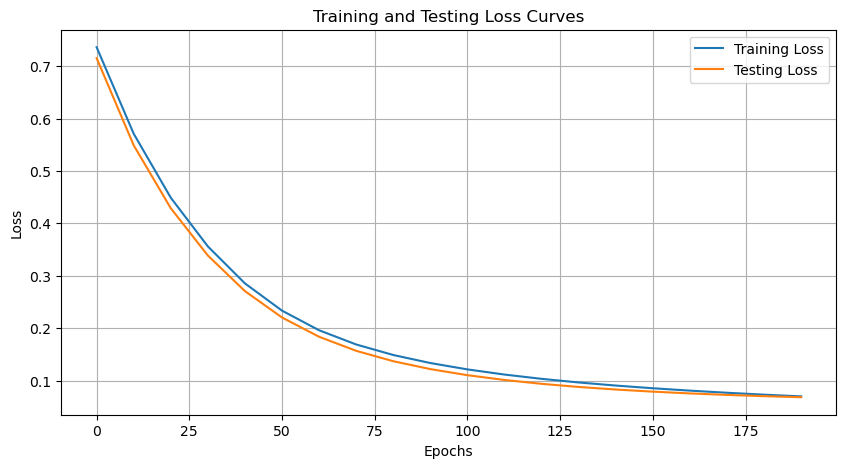

In [222]:
plt.figure(figsize=(10,5))

train_loss = np.array(loss_values)
test_loss = np.array(test_loss_values)

plt.plot(epoch_count, train_loss, label='Training Loss')
plt.plot(epoch_count, test_loss, label='Testing Loss')
plt.title('Training and Testing Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Graphing Training and Testing Accuracy

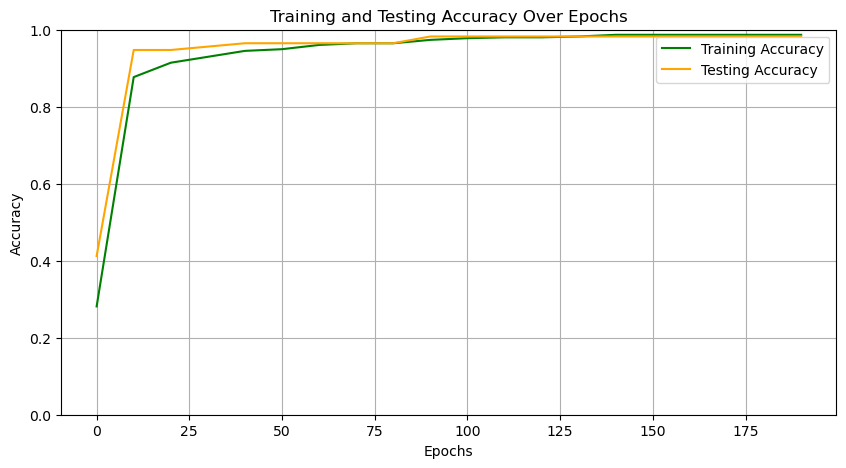

In [223]:
plt.figure(figsize=(10,5))

train_acc = np.array(train_accuracy_values)
test_acc = np.array(test_accuracy_values)

plt.plot(epoch_count, train_acc, label='Training Accuracy', color='green')
plt.plot(epoch_count, test_acc, label='Testing Accuracy', color='orange')

plt.title('Training and Testing Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

Metrics & Insights
- k-Nearest Neighbors (KNN): 95% Accuracy
- Decision Tree Classifier: 95% Accuracy
- Random Forest Classifier (RFC): 96% Accuracy
- Logistic Regression: 96% Accuracy
- Support Vector Machine (SVM): 98% Accuracy
- Neural Network (PyTorch): 98.25% Accuracy